# Hybrid workflow for molecular simulations

In this tutorial we implement a quantum-classical hybrid workflow for computing the ground state energies of a stronlgy interacting molecular system. The algorithm is made of two parts
1. a variational quantum eigensolver that uses a quantum-number-preserving ansatz proposed by [Anselmetti et al. (2021)](https://doi.org/10.1088/1367-2630/ac2cb3) to produce a quantum trial wave function $|\Psi_T\rangle$. This is implemented via cudaq.
2. an auxiliary-field quantum Monte Carlo that realizes a classical imaginary time evolution and collects the ground state energy estimates

## Variational Quantum Eigensolver (VQE)

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt

# from pyscf import gto, scf, ao2mo, mcscf

# from openfermion import jordan_wigner
# from openfermion import generate_hamiltonian

# #Package installs and relevant imports

# # !pip install pyscf==2.6.0
# # !pip install openfermion==1.6.1
# # !echo cuda-quantum | sudo -S apt-get install -y cuda-toolkit-11.8 && python -m pip install cupy==13.1.0
# # !pip install git+https://github.com/yfhuang93/ipie/tree/msd_gpu
# # !pip install ipie==0.7.0


# import numpy as np
# import matplotlib.pyplot as plt

# from pyscf import gto, scf, ao2mo, mcscf

# from openfermion import jordan_wigner
# from openfermion import generate_hamiltonian

# from src.vqe_cudaq_qnp import VQE
# from src.vqe_cudaq_qnp import get_cudaq_hamiltonian
# from src.utils_ipie import get_coeff_wf, gen_ipie_input_from_pyscf_chk

# from ipie.config import config
# config.update_option("use_gpu", True)
# from ipie.hamiltonians.generic import Generic as HamGeneric
# from ipie.qmc.afqmc import AFQMC
# from ipie.systems.generic import Generic
# from ipie.trial_wavefunction.particle_hole import ParticleHole
# from ipie.analysis.extraction import extract_observable

#Package installs and relevant imports

# !pip install pyscf==2.6.0
# !pip install openfermion==1.6.1
# !echo cuda-quantum | sudo -S apt-get install -y cuda-toolkit-11.8 && python -m pip install cupy==13.1.0
# !pip install git+https://github.com/yfhuang93/ipie/tree/msd_gpu
# !pip install ipie==0.7.0


import numpy as np
import matplotlib.pyplot as plt

from pyscf import gto, scf, ao2mo, mcscf

from openfermion import jordan_wigner
from openfermion import generate_hamiltonian

from src.vqe_cudaq_qnp import VQE
from src.vqe_cudaq_qnp import get_cudaq_hamiltonian
from src.utils_ipie import get_coeff_wf, gen_ipie_input_from_pyscf_chk

from ipie.config import config
config.update_option("use_gpu", True)
from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.particle_hole import ParticleHole
from ipie.analysis.extraction import extract_observable

We start by define the structure, the basis set, and the spin of the molecule. We build the molecule object with PySCF and run a preliminary Hartree-Fock computation. Here we choose as an example a [chelating agent](https://doi.org/10.1021/acs.jctc.3c01375) representing a relevant class of substances industrially produced at large scale. Their use ranges, among the others, from water softeners in cleaning applications, modulators of redox behavior in oxidative bleaching, scale suppressants, soil remediation and ligands for catalysts. In particular we focus here in a Fe(III)-NTA complex whose structure is given in the `geo.xyz` file.

In [52]:
# Define the molecular structure and the basis set for the molecule
atom = "systems/geo_o3.xyz"
basis = "cc-pVTZ"
spin = 0
num_active_orbitals = 9
num_active_electrons = 12

In [53]:
# PYSCF 
# Define the molecule 
molecule = gto.M(
    atom=atom,
    spin=spin,
    basis=basis,
    verbose=0
)

mol_nelec = molecule.nelec
hartee_fock = scf.ROHF(molecule)
hartee_fock.chkfile = "scf.chk"

# Run Hartee-Fock
hartee_fock.kernel()

-224.34048064812222

### Hamiltonian preparation for VQE

Since this molecule contains around 600 orbitals (which would correspond to 1200 qubits) and 143 total electrons, it is impossible to perform a full VQE in the current generation of simulators. Therefore we need to identify an active space with fewer orbitals and electrons that contribute to the the stronlgy interacting part of the whole molecule. We then run a post-HF computation with the PySCF's built-in CASCI method in order to obtain the one-body ($t_{pq}$) and two-body ($V_{prqs}$) integrals that define the molecular Hamiltonian in the active space

$$ H= \sum_{pq}t_{pq}\hat{a}_{p}^\dagger \hat {a}_{q}+\sum_{pqrs}  V_{prqs}\hat a_{p}^\dagger \hat a_{q}^\dagger \hat a_{s}\hat a_{r}$$

Here we choose an active space made by 5 orbitals and we populate them with 5 electrons.

In [54]:
# Run a casci simulation for computing the Hamiltonian in the active space
casci = mcscf.CASCI(hartee_fock, num_active_orbitals, num_active_electrons)
# ss = (molecule.spin / 2 * (molecule.spin / 2 + 1))
casci.fix_spin_(ss= (molecule.spin / 2 * (molecule.spin / 2 + 1)))

e_tot, e_cas, fcivec, mo_output, mo_energy = casci.kernel()

# Compute the one-body (h1) and two-body integrals (tbi)
h1, energy_core = casci.get_h1eff()
h2 = casci.get_h2eff()
h2_no_symmetry = ao2mo.restore('1', h2, num_active_orbitals)
tbi = np.asarray(h2_no_symmetry.transpose(0, 2, 3, 1), order='C')

# Compute the Hamiltonian and convert it to a CUDA-Q operator
mol_ham = generate_hamiltonian(h1, tbi, energy_core.item())
jw_hamiltonian = jordan_wigner(mol_ham)
hamiltonian_cudaq, energy_core = get_cudaq_hamiltonian(jw_hamiltonian)

### Run VQE with CUDA-Q

We can now run the quantum-number-preserving VQE using CUDA-Q. We can choose some options (the number of layers, the maximum number of optimization steps) for the VQE. At the end of the VQE, we store the final state vector that will be used in the classical AFQMC computation.

In [55]:
# Define some options for the VQE
options = {'n_vqe_layers': 1,
           'maxiter': 100,
           'energy_core': energy_core,
           'return_final_state_vec': True}

n_qubits = 2 * num_active_orbitals

vqe = VQE(n_qubits=n_qubits,
             num_active_electrons=num_active_electrons,
             spin=spin,
             options=options)

results = vqe.execute(hamiltonian_cudaq)

# Best energy from VQE
energy_optimized = results['energy_optimized']

# Final state vector
final_state_vector = results["state_vec"]

# List with the energies for all the optimization iterations
vqe_energies = results["callback_energies"]

# Using cudaq optimizer
# Num Params: 16
# Qubits: 18
# N_layers: 1
# Energy after the VQE: -224.3945354384087


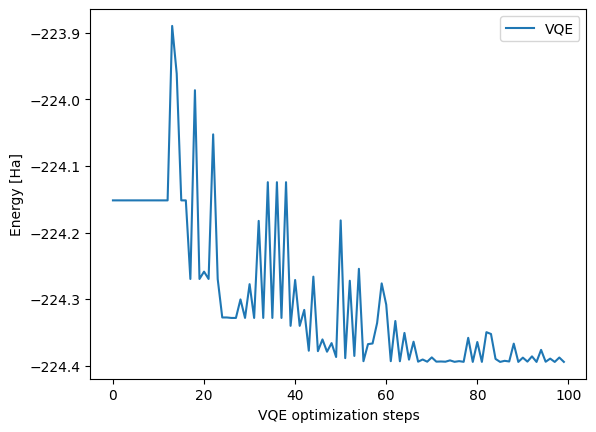

In [56]:
plt.xlabel("VQE optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(vqe_energies, label="VQE")
plt.legend()

### Auxiliary field quantum Monte Carlo (AFQMC)

AFQMC is a numerical method for computing relevant properties of strongly interacting molecules. AFQMC is a type of quantum Monte Carlo method that combines the use of random walks with an auxiliary field to simulate the imaginary-time evolution of a quantum system and drive it to the lowest energy state. This method can provide accurate results for ground-state properties of a wide range of physical systems, including atoms, molecules, and solids. Here we summarize the main features of AFQMC while a detailed introduction to can be found at this [link](https://www.cond-mat.de/events/correl13/manuscripts/zhang.pdf).  

We consider the electronic Hamiltonian in the second quantization
\begin{equation}
H = {H}_1 + {H}_2 
=\sum_{pq} h_{pq} {a}_{p}^{\dagger} {a}_{q} + \frac{1}{2} \sum_{pqrs} v_{pqrs}{a}_{p}^{\dagger} {a}_r {a}^{\dagger}_{q} {a}_s, \tag{1}
\end{equation}
where ${a}_{p}^{\dagger}$ and ${a}_{q}$ are fermionic creation and annihilation operators of orbitals $p$ and $q$, respectively. The terms $h_{pq} $ and $v_{pqrs}$ are the matrix elements of the one-body $H_1$ and two-body interactions $H_2$ of $H$, respectively. Here, we omit the spin indices for simplicity. 

AFQMC realizes an imaginary time propagation of an initial state (chosed as a Slater determinant) $\ket{\Psi_{I}}$ towards the ground state $\ket{\Psi_0}$ of $H$ with
\begin{equation}
\ket{\Psi_0} \sim\lim_{n \to \infty} \left[ e^{-\Delta\tau H  }  \right]^{n} \ket{\Psi_{I}}
\end{equation} 
where $\Delta\tau$ is the imaginary time step.

AFQMC relies on decomposing the two-body interactions $H_2$ in terms of sum of squares of one-body operators ${v}_\gamma$ such that the Hamiltonian ${H}$ becomes
\begin{equation}
H = v_0 - \frac{1}{2}\sum_{\gamma=1}^{N_\gamma} {v}_\gamma^2
\end{equation}
with ${v}_0 = {H}_1 $ and $
{v}_\gamma = i \sum_{pq} L^{\gamma}_{pq} {a}_{p}^{\dagger}{a}_{q}.
$
The $N_\gamma$ matrices $L^{\gamma}_{pq}$ are called Cholesky vectors as they are  obtained via a Cholesky decomposition of the two-body matrix elements $v_{pqrs}$ via $v_{pqrs} = \sum_{\gamma=1}^{N_\gamma} L^{\gamma}_{pr} L^{\gamma}_{qs}$.

The imaginary time propagation evolves an esemble of walkers $\{\phi^{(n)}\}$ (that are Slater determinants) and allows one to access observables of the system. For example, the local energy
\begin{equation}
    \mathcal{E}_{\text{loc}}(\phi^{(n)}) = \frac{\bra{\Psi_\mathrm{T}}H\ket{\phi^{(n)}}}{\braket{\Psi_\mathrm{T}| \phi^{(n)}}}
\end{equation}
defined as the mixed expectation value of the Hamiltonian with the trial wave function $\ket{\Psi_\mathrm{T}}$.


The trial wavefunction can be in general a single Slater determinant or a multi-Slater determinant trial states coming e.g. from VQE. This will help in achieving more accurate ground state energy estimates.


The implementation for AFQMC we use here is the one from [`ipie`](https://github.com/JoonhoLee-Group/ipie) that supports both CPUs and GPUs and requires different steps:
1. preparation of the molecular Hamiltonian (1) by performing the Cholesky decomposition
2. preparation of the trial state from the VQE wave function
3. AFQMC run

### Preparation of the molecular Hamiltonian

In [57]:
from ipie.config import config
config.update_option("use_gpu", False)
from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.particle_hole import ParticleHole
from ipie.analysis.extraction import extract_observable

In [58]:
#AFQMC

# Generate the input Hamiltonian for ipie from the chk file from pyscf
ipie_ham  = gen_ipie_input_from_pyscf_chk("scf.chk",
                                          mcscf=True,
                                          chol_cut=1e-5)

h1e, cholesky_vectors, e0  = ipie_ham 

num_basis = cholesky_vectors.shape[1]
num_chol = cholesky_vectors.shape[0]

system = Generic(nelec=mol_nelec)

ham = HamGeneric(
    np.array([h1e, h1e]),
    cholesky_vectors.transpose((1, 2, 0)).reshape((num_basis * num_basis, num_chol)),
    e0,
)

# Number of electrons in simulation: (12, 12)


### Preparation of the trial wave function

In [59]:
# Build the trial wavefunction from the state vector computed via VQE
wavefunction = get_coeff_wf(final_state_vector,
                            n_active_elec=num_active_electrons,
                            spin=spin
                           )

trial = ParticleHole(
    wavefunction,
    mol_nelec,
    num_basis,
    num_dets_for_props=len(wavefunction[0]),
    verbose=False)  #set to true if needed

trial.compute_trial_energy = True
trial.build()
trial.half_rotate(ham)
####################

### Set-up of the AFQMC parameters

Here we can choose the input options like the timestep $\Delta\tau$, the total number of walkers `num_walkers` and the total number of AFQMC iterations `num_blocks`.

In [60]:
# Set the AFQMC parameters (num_walkers, num_blocks,...) here 
afqmc_msd = AFQMC.build(
    mol_nelec,
    ham,
    trial,
    num_walkers=100,
    num_steps_per_block=25,
    num_blocks=10,
    timestep=0.005,
    stabilize_freq=5,
    seed=96264512,
    pop_control_freq=5,
    verbose=False,
)

# random seed is 96264512


In [61]:
# Run the AFQMC
afqmc_msd.run()
afqmc_msd.finalise(verbose=False)

            Block                   Weight            WeightFactor            HybridEnergy                  ENumer                  EDenom                  ETotal                  E1Body                  E2Body
                0   1.0000000000000000e+02  1.0000000000000000e+02  0.0000000000000000e+00 -2.2439416883037411e+04  1.0000000000000000e+02 -2.2439416883037413e+02 -3.7639365201745517e+02  1.5199948318708113e+02
                1   4.2258273768161757e+02  1.4118653472267843e+03 -1.1708876340868197e+02 -2.2474921561413157e+04  1.0000000000000001e+02 -2.2474921561413154e+02 -3.7647295761526891e+02  1.5172374200113737e+02
                2   1.0031503625237428e+02  3.8297710748551305e+02 -1.1739917192759658e+02 -2.2490537203825694e+04  1.0000000000000000e+02 -2.2490537203825693e+02 -3.7651469905957731e+02  1.5160932702132038e+02
                3   9.9899190068440575e+01  1.0007736593569858e+02 -1.1733623599094014e+02 -2.2497025249179875e+04  1.0000000000000001e+02 -2.24970252491798

We can extract and plot the energy estimated 

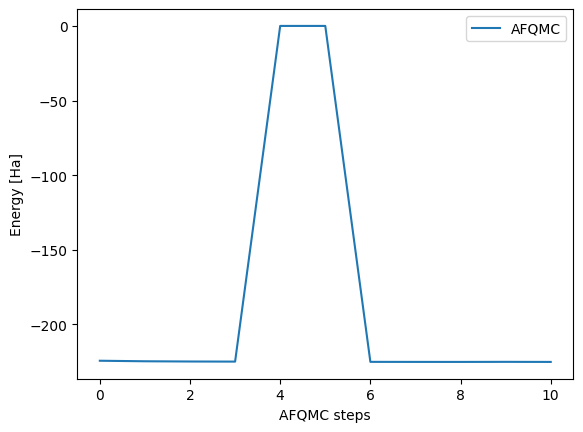

In [62]:
qmc_data = extract_observable(afqmc_msd.estimators.filename, "energy")
plt.xlabel("AFQMC steps")
plt.ylabel("Energy [Ha]")
plt.plot(qmc_data["ETotal"], label="AFQMC")
plt.legend()

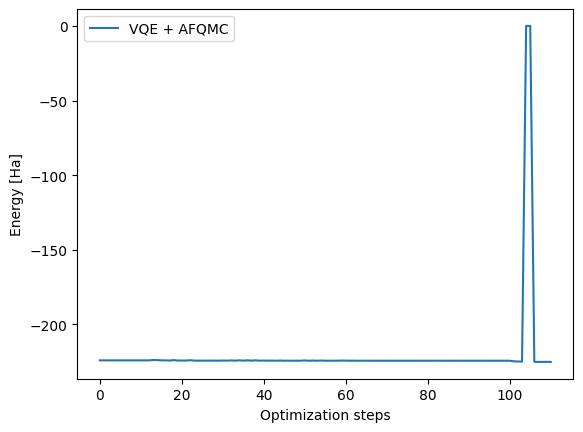

In [63]:
x = vqe_energies + list(qmc_data["ETotal"])
y = list(range(len(x)))

plt.xlabel("Optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(y, x, label="VQE + AFQMC")
plt.legend()